### Comparison of the coherence metric between the original and surrogate data

In [13]:
# Path to the toolbox
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mne.viz import plot_connectivity_circle
from tqdm import tqdm

import GDa.graphics.plot as plot

In [2]:
SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = plot.set_plot_config()

In [3]:
# Create directory to save figures
if not os.path.exists("img/n3.0.4"):
    os.makedirs("img/n3.0.4")

In [4]:
# Extract area names
def _extract_roi(roi, sep):
    # Code by Etiene
    x_s, x_t = [], []
    for r in roi:
        _x_s, _x_t = r.split(sep)
        x_s.append(_x_s), x_t.append(_x_t)
    roi_c = np.c_[x_s, x_t]
    idx = np.argsort(np.char.lower(roi_c.astype(str)), axis=1)
    roi_s, roi_t = np.c_[[r[i] for r, i in zip(roi_c, idx)]].T
    roi_st = [f"{s}{sep}{t}" for s, t in zip(roi_s, roi_t)]
    return roi_s, roi_t

#### Load data

In [127]:
p_mat = pd.read_csv(
    "/home/vinicius/storage1/projects/GrayData-Analysis/Results/lucy/significance_analysis/n_edges_0.csv"
)

In [128]:
del p_mat["Unnamed: 0"]

In [159]:
freqs = np.unique(p_mat.freqs.values)
test = np.unique(p_mat.p.values)

### Plotting number of siginificant links for each pair of regions

In [173]:
def plot_maps(frequency: float = 3.0, test: str = "t"):

    n_edges = p_mat[p_mat.p.eq(test) & p_mat.freqs.eq(frequency)].n_edges.values
    roi_s = p_mat[p_mat.p.eq(test) & p_mat.freqs.eq(frequency)].sources.values
    roi_t = p_mat[p_mat.p.eq(test) & p_mat.freqs.eq(frequency)].targets.values

    unique_rois = np.unique(np.stack((roi_s, roi_t)))
    n_rois = len(unique_rois)
    n_pairs = len(roi_s)

    mapping = dict(zip(unique_rois, np.arange(n_rois)))

    x_s, x_t = [], []
    for s, t in zip(roi_s, roi_t):
        x_s.append(mapping[s])
        x_t.append(mapping[t])

    plot_connectivity_circle(
        n_edges,
        indices=(
            np.array(x_s),
            np.array(x_t),
        ),
        node_names=unique_rois,
        colormap="hot_r",
        facecolor="white",
        vmin=20,
        vmax=70,
        textcolor="k",
        fig=fig,
        colorbar=False,
        padding=3,
        colorbar_size=0.4,
        colorbar_pos=(0, 0.5),
        linewidth=3,
        fontsize_title=20,
        fontsize_names=12,
        subplot=(111),
        show=False,
    )

    plt.savefig(
        f"img/n3.0.4/sig_links_b{frequency}_{test}_test.png",
        transparent=True,
        bbox_inches="tight",
        dpi=300,
    )
    plt.close()


def plot_circles(ax, frequency: float = 3.0, test: str = "t"):
    plt.sca(ax)
    png = plt.imread(f"img/n3.0.4/sig_links_b{frequency}_{test}_test.png")
    im = plt.imshow(png, interpolation="none")
    plt.axis("off")
    pad = 2
    plt.xlim(-pad, png.shape[1] + pad)
    plt.ylim(png.shape[0] + pad, -pad)

In [161]:
# Save conn. maps
for f in tqdm(freqs):
    for t in test:
        plot_maps(frequency=f, test=t)

100%|████████████████████████████████████████████████████| 10/10 [02:51<00:00, 17.20s/it]


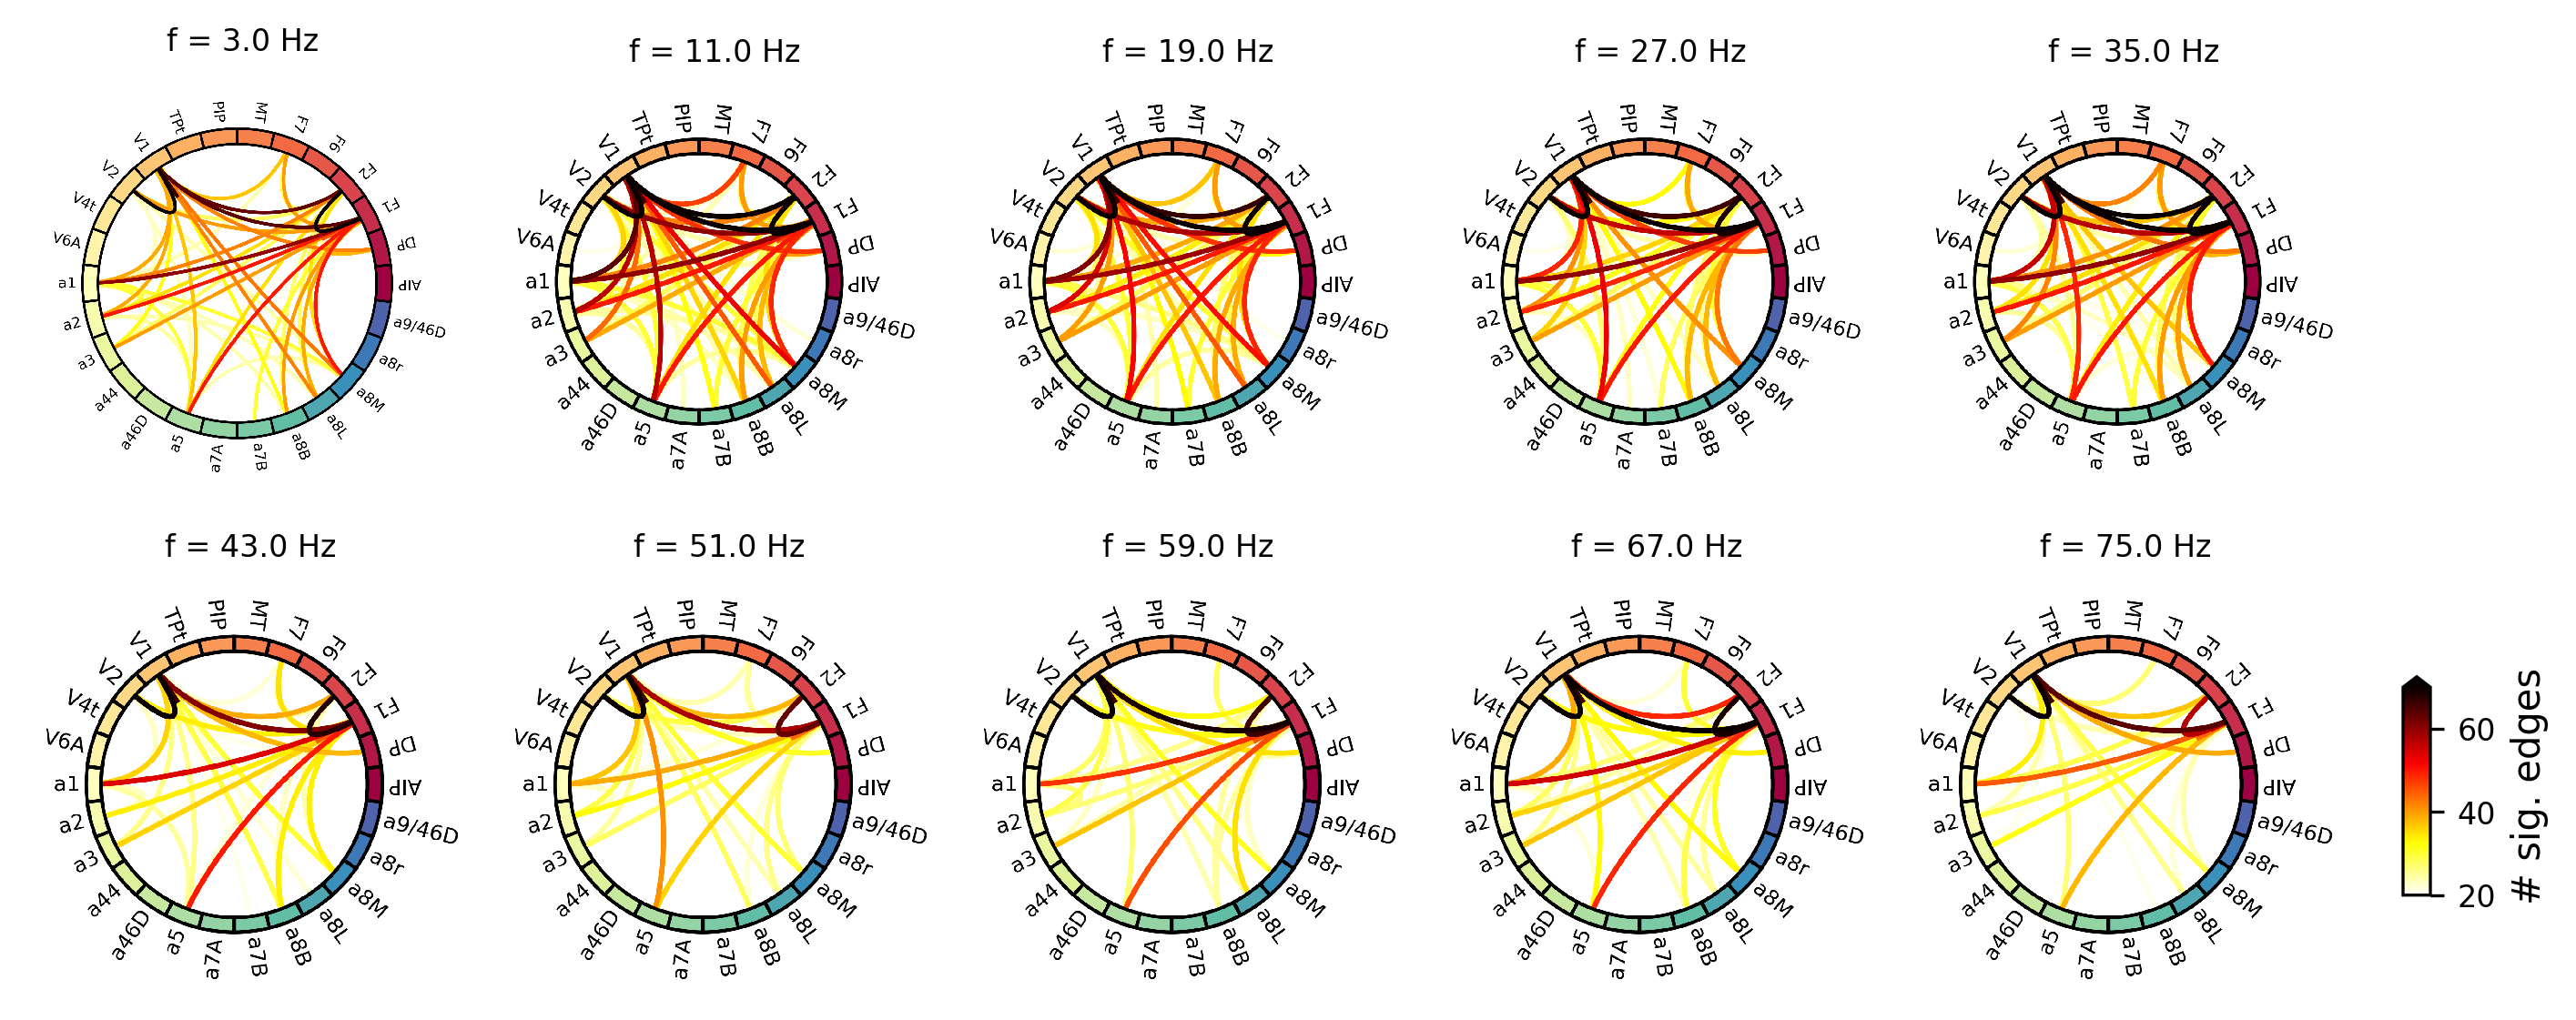

In [200]:
fig = plt.figure(figsize=(10, 4), dpi=300)

gs1 = fig.add_gridspec(
    nrows=1,
    ncols=5,
    left=0.05,
    right=0.90,
    bottom=0.5,
    top=0.92,
    wspace=0.1,
    hspace=0,
)
gs2 = fig.add_gridspec(
    nrows=1,
    ncols=5,
    left=0.05,
    right=0.90,
    bottom=0.0,
    top=0.5,
    wspace=0.05,
    hspace=0,
)

gs3 = fig.add_gridspec(
    nrows=1,
    ncols=1,
    left=0.92,
    right=0.93,
    bottom=0.15,
    top=0.35,
    wspace=0.05,
    hspace=0,
)

# Top row
ax1 = plt.subplot(gs1[0])
ax2 = plt.subplot(gs1[1])
ax3 = plt.subplot(gs1[2])
ax4 = plt.subplot(gs1[3])
ax5 = plt.subplot(gs1[4])


# Bottom row
ax6 = plt.subplot(gs2[0])
ax7 = plt.subplot(gs2[1])
ax8 = plt.subplot(gs2[2])
ax9 = plt.subplot(gs2[3])
ax10 = plt.subplot(gs2[4])

ax_list = fig.get_axes()

for i, ax in enumerate(ax_list):
    plot_circles(ax, frequency=freqs[i], test="t")
    plt.title(f"f = {freqs[i]} Hz")

# Colorbar
ax11 = plt.subplot(gs3[0])

norm = matplotlib.colors.Normalize(vmin=20, vmax=70)
cbar = plt.colorbar(
    mappable=plt.cm.ScalarMappable(cmap=matplotlib.cm.hot_r, norm=norm),
    cax=ax11,
    extend="max",
)
cbar.ax.set_ylabel("# sig. edges", rotation="vertical");